### Libraries

In [ ]:
# !pip install lime
# !pip install shap

In [12]:
from sklearn.datasets import fetch_california_housing
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn import datasets, ensemble

import shap
import lime
from lime.lime_tabular import LimeTabularExplainer
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd

from skopt import BayesSearchCV


#### Load dataset - housing from sklearn

In [15]:
housing = fetch_california_housing()
# housing = pd.DataFrame(data=data.data, columns=data.feature_names)
housing.target

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

In [16]:
housing.feature_names

['MedInc',
 'HouseAge',
 'AveRooms',
 'AveBedrms',
 'Population',
 'AveOccup',
 'Latitude',
 'Longitude']

#### Create XGBoost model 

In [26]:
# split data 
X_train, X_test, y_train, y_test = train_test_split(housing.data, housing.target, test_size=0.2, random_state=42)

# create model
model = XGBRegressor()

# parameter grid
param_grid = {
    'booster': ['gblinear', 'gbtree'],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'subsample': [0.5, 0.6, 0.7, .8, .9, 1],
    'colsample_bytree': [0.5, 0.6, 0.7, .8, .9, 1]
}


#### Tune and train model

In [28]:
# BayesSearchCV
grid_bayes = BayesSearchCV(estimator=model,
                    search_spaces=param_grid,
                    cv=5,
                    n_jobs=-1,
                    random_state=1,
                    verbose = 5)

# Fit the grid search to the data
grid_bayes.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_bayes.best_params_
best_model = grid_bayes.best_estimator_

print(f"Best Parameters: {best_params}")

# Make predictions on the test set with the best model
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### Model with best params

In [49]:
best_model = XGBRegressor(booster = 'gbtree',
                     colsample_bytree = 0.8,
                     learning_rate = 0.1,
                     max_depth = 9,
                     n_estimators = 300,
                     subsample = 0.9)
# fit best model
best_model.fit(X_train, y_train)

# Make predictions on the test set with the best model
y_pred = best_model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 0.44812714690055244


C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [30]:
best_params

OrderedDict([('booster', 'gbtree'),
             ('colsample_bytree', 0.8),
             ('learning_rate', 0.1),
             ('max_depth', 9),
             ('n_estimators', 300),
             ('subsample', 0.9)])

In [44]:
# R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

R-squared: 0.8467517064338124


### Library shap

[Documentation](https://shap.readthedocs.io/en/latest/index.html)

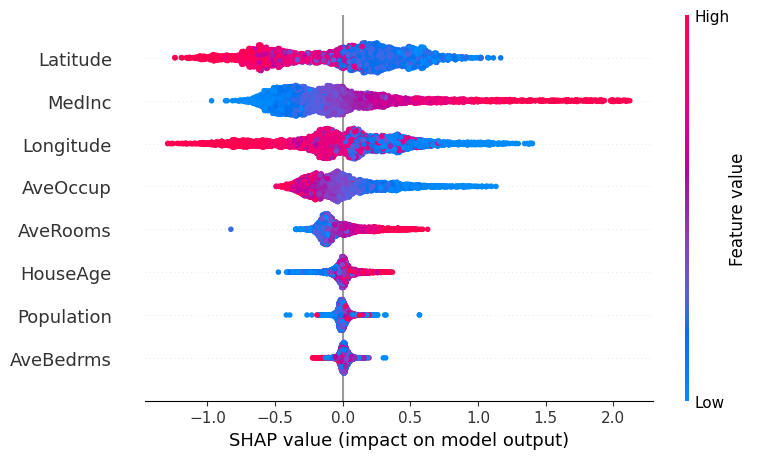

In [32]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)

shap.summary_plot(shap_values, X_test, feature_names=housing.feature_names)

[**Learn more about interpretation of plots**](https://www.datacamp.com/tutorial/explainable-ai-understanding-and-trusting-machine-learning-models)

**Feature importance:** The top feature (Latitude) has the most impact of the model's output, while AveBedrm has the least impact. 

**Impact on model output:** High values of Latitude (pink) have a positive impact on model output. 

**Feature value:** Color represents the feature value: pink indicate higher values and blue - lower. Example: higher values of latitude have positive impact on the prediction.

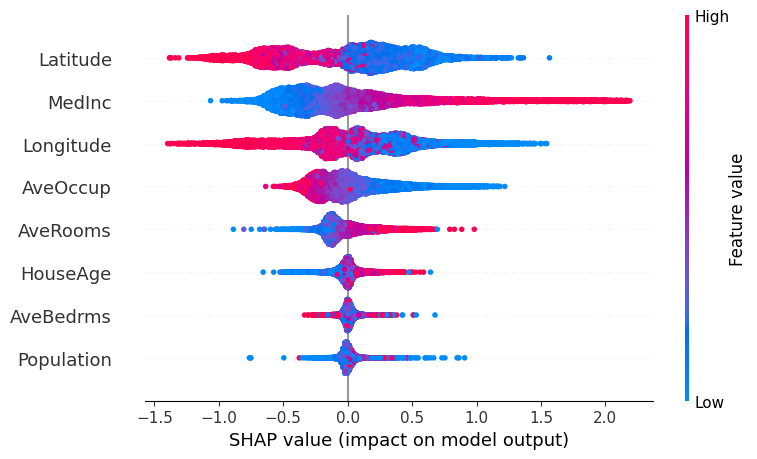

In [46]:
# Explain how model was made
explainer_train = shap.Explainer(best_model)
shap_values_train = explainer(X_train)
shap.summary_plot(shap_values_train, X_train, feature_names=housing.feature_names)

As you can see, both graphs look similar. Latitude had the largest impact on the model, but population had the smallest impact.

### For some reason it doesn't work (dependence plot)


In [63]:
# Dependence plot for a specific feature
# shap.dependence_plot("Latitude", shap_values, X_test, feature_names=housing.feature_names)

### Library lime

[Documentation](https://lime-ml.readthedocs.io/en/latest/)

In [80]:
explainer_lime = LimeTabularExplainer(X_train, 
                                 feature_names=housing.feature_names, 
                                 class_names=['Price'], 
                                 mode='regression')

# Choose a random instance for explanation
i = np.random.randint(0, X_test.shape[0])
exp = explainer_lime.explain_instance(X_test[i], best_model.predict, num_features=5)

print(f"Explaining instance number: {i}")
print("Specific row of data in dataset: ") 
print(X_test[i])

# Visualize the explanation
exp.show_in_notebook(show_table=True)

Explaining instance number: 2370
Specific row of data in dataset: 
[   7.9887       15.            6.83713355    1.04885993  873.
    2.84364821   33.69       -117.8       ]


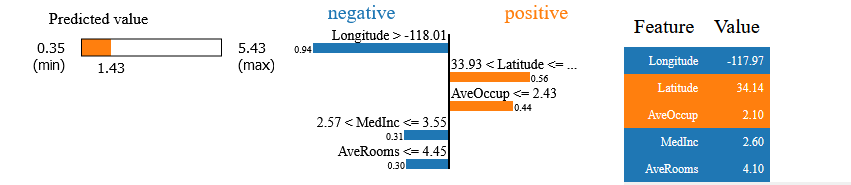

**Sample explanation of the plot above**

**Features:** The features are listed in table. These are the variables in dataset that the model uses to make predictions.

**Feature Values:** The values next to the feature names are the actual values of these features for the specific instance being explained.

**Weights:** The weights or coefficients are listed in the center of the plot ('negative', 'positive'). These values represent the effect of each feature on the prediction for this specific instance. A positive weight means that the feature pushes the prediction higher, while a negative weight means it pushes the prediction lower.

**Prediction:** The orange line within this range represents the actual prediction for this instance.

### California housing train - data

In [2]:
data = pd.read_csv("dane/california_housing_train.csv")

# Display basic information about the dataset
print(data.info())
print(data.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB
None
(17000, 9)


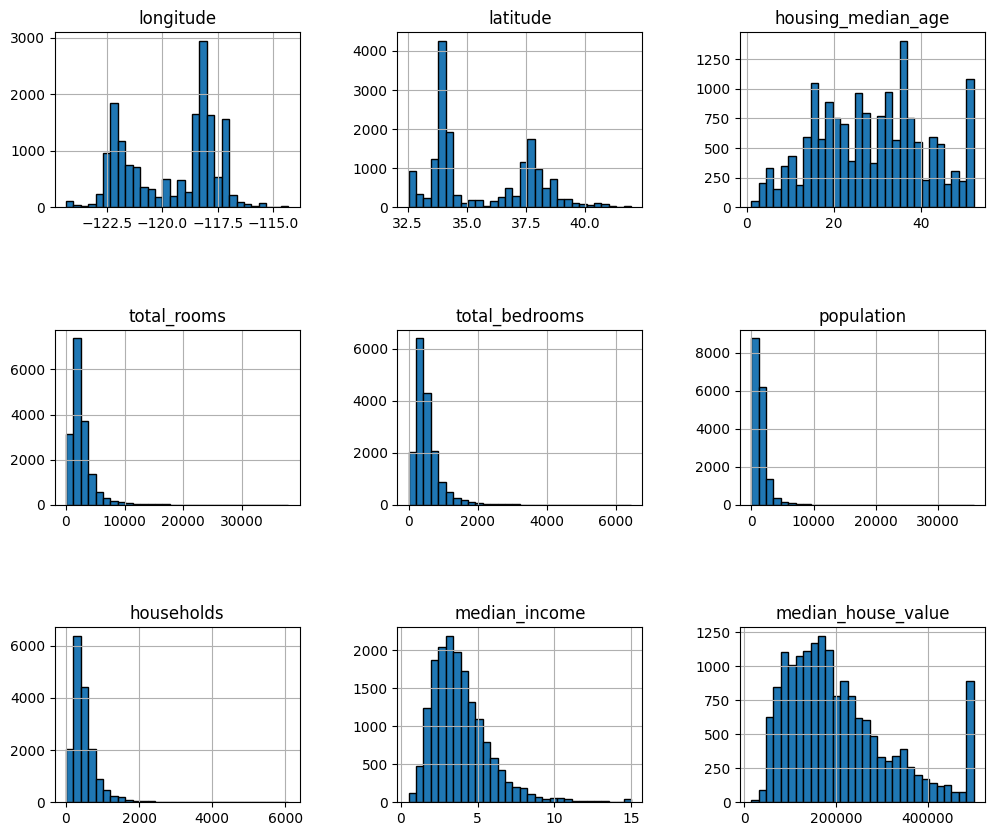

In [3]:
data.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

In [4]:
data['households'].replace("no", np.nan , inplace=True)
data['total_bedrooms'] = data['total_bedrooms'].fillna(data['total_bedrooms'].mean())
X = data.drop(["median_house_value"],axis=1)
y = data.median_house_value

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=13)

The mean squared error (RMSE) Decision tree on test set: 69501.2933
The median absolute error (MAE) Decision tree on test set: 25350.0000


<Axes: >

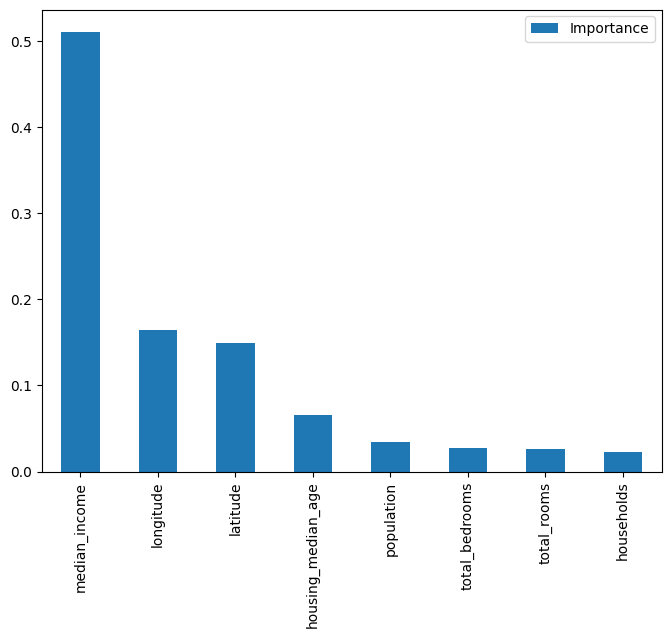

In [10]:
# create a regressor object
regressor = DecisionTreeRegressor(random_state = 13)

# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, regressor.predict(X_test)))
median_err = median_absolute_error(y_test, regressor.predict(X_test))
print("The mean squared error (RMSE) Decision tree on test set: {:.4f}".format(rmse))
print("The median absolute error (MAE) Decision tree on test set: {:.4f}".format(median_err))

feat_importances = pd.DataFrame(regressor.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

The root mean squared error (RMSE) XGBoost on test set: 53071.7766
The median absolute error (MAE) XGBoost on test set: 26629.5511


<Axes: >

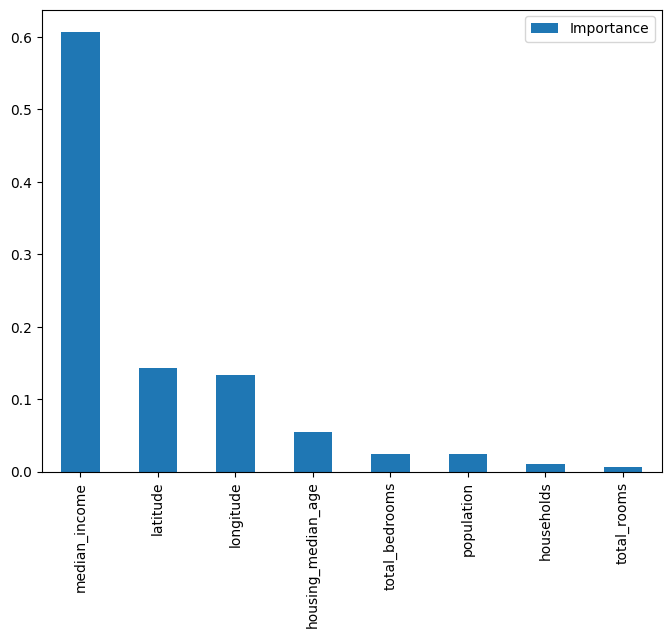

In [13]:
reg = ensemble.GradientBoostingRegressor()
reg.fit(X_train, y_train)

rmse = np.sqrt(mean_squared_error(y_test, reg.predict(X_test)))
median_err = median_absolute_error(y_test, reg.predict(X_test))
print("The root mean squared error (RMSE) XGBoost on test set: {:.4f}".format(rmse))
print("The median absolute error (MAE) XGBoost on test set: {:.4f}".format(median_err))

feat_importances = pd.DataFrame(reg.feature_importances_, index=X_train.columns, columns=["Importance"])
feat_importances.sort_values(by='Importance', ascending=False, inplace=True)
feat_importances.plot(kind='bar', figsize=(8,6))

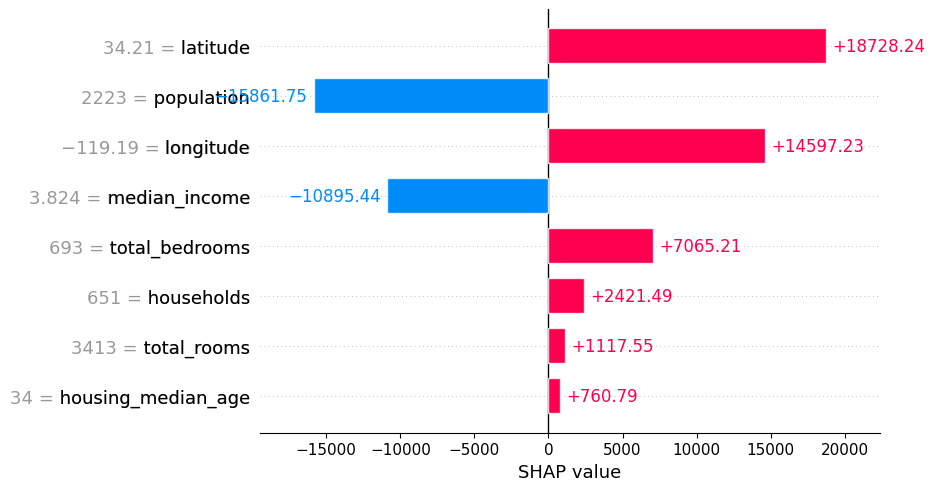

longitude             -119.1900
latitude                34.2100
housing_median_age      34.0000
total_rooms           3413.0000
total_bedrooms         693.0000
population            2223.0000
households             651.0000
median_income            3.8239
Name: 9362, dtype: float64


In [14]:
shap.initjs()
# Create the explainer
explainer = shap.Explainer(reg, feature_names = X_train.columns)
# Evaluate SHAP values
shap_values = explainer.shap_values(X_test)
shap.plots.bar(explainer(X_test.values[30]))
print(X_test.iloc[30])

C:\Users\Karolina\anaconda3\envs\Magisterka\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but GradientBoostingRegressor was fitted with feature names
  warnings.warn(


Intercept 216334.81686138586
Prediction_local [353210.40815204]
Right: 225434.9505062694


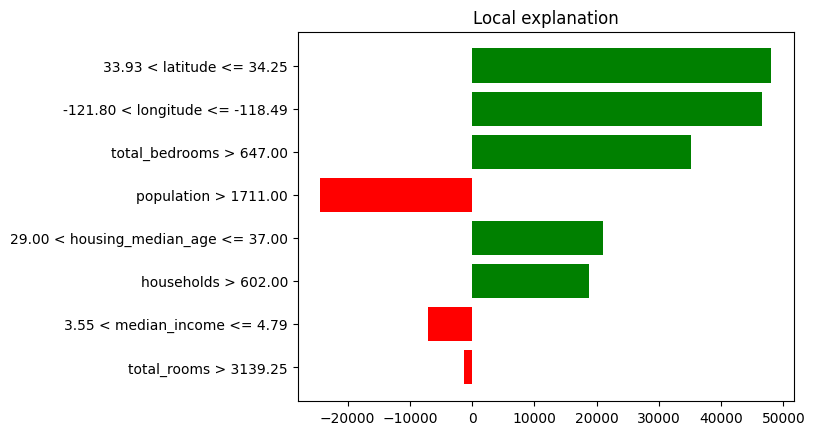

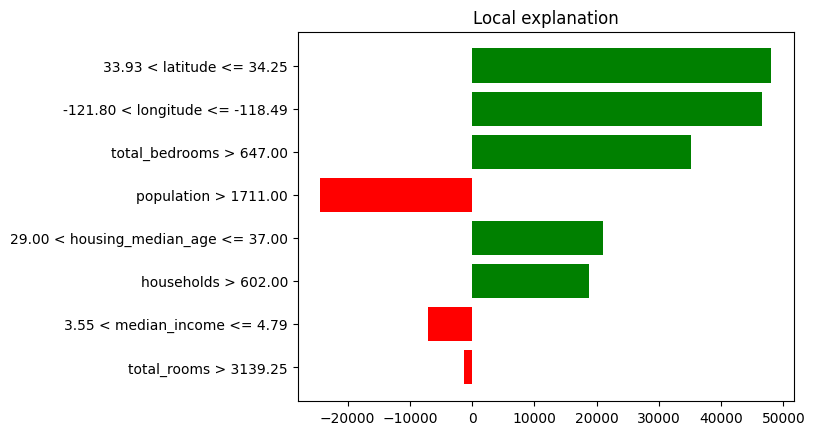

In [15]:
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns.values.tolist(),
                                                  class_names=['median_house_value'], verbose=True, mode='regression')

# Choose the 5th instance and use it to predict the results
exp = explainer.explain_instance(X_test.values[30], reg.predict, num_features=8)
exp.as_pyplot_figure()

In [16]:
shap_values = explainer.shap_values(X_test)
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
shap.summary_plot(shap_values, X_test)

AttributeError: 'LimeTabularExplainer' object has no attribute 'shap_values'